In [158]:
# !pip install streamlit
import os
from mlflow import log_metric, log_param, log_artifacts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import mlflow

pd.set_option("display.max_columns", 100)

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment('FluShotLearning')

<Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='FluShotLearning', tags={}>

# Data importing

via Google Mount

In [159]:
# from google.colab import drive
# drive.mount('/content/drive')

# train_features = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Flu Shot Learning/data/training_set_features.csv", index_col="respondent_id")
# train_labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Flu Shot Learning/data/training_set_labels.csv", index_col="respondent_id")
# test_features = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Flu Shot Learning/data/test_set_features.csv", index_col="respondent_id")

via Uploading files

In [160]:
train_features = pd.read_csv(r"C:\Development\FluShotLearning\data\training_set_features.csv", index_col="respondent_id",engine='python')
train_labels = pd.read_csv(r"C:\Development\FluShotLearning\data\training_set_labels.csv", index_col="respondent_id", engine='python')
test_features = pd.read_csv(r"C:\Development\FluShotLearning\data\test_set_features.csv", index_col="respondent_id", engine='python')

In [161]:
train_features.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [162]:
train_features.shape

(26707, 35)

In [163]:
train_features.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [164]:
train_labels.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [165]:
train_labels.shape

(26707, 2)

# EDA

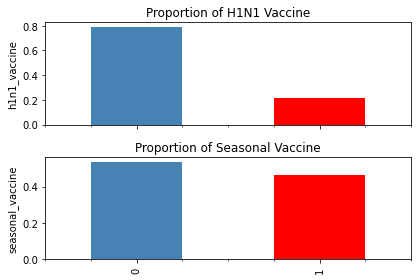

In [166]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = train_labels.shape[0]

(train_labels['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot(kind='bar', stacked=True,title="Proportion of H1N1 Vaccine", color=['steelblue', 'red'],ax=ax[0]))

ax[0].set_ylabel("h1n1_vaccine")

(train_labels['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot(kind='bar', stacked=True,title="Proportion of Seasonal Vaccine", color=['steelblue', 'red'],ax=ax[1]))

ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()


In [167]:
joined_df = train_features.join(train_labels)
print(joined_df.shape)
joined_df.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


In [168]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()



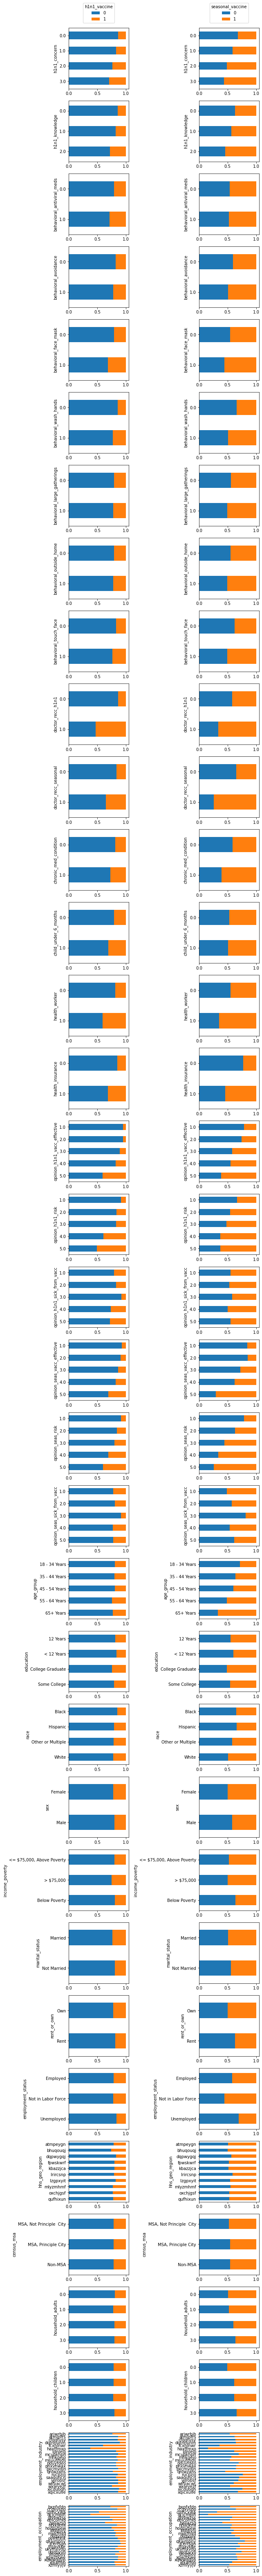

In [169]:
cols_to_plot = train_features.columns.tolist()

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

For correlation between features and variable we should use Cramer's V, or Theil's u

In [170]:
def histograms_numeric_columns(df, numerical_columns):
    '''
    Takes df, numerical columns as list
    Returns a group of histagrams
    '''
    f = pd.melt(df, value_vars=numerical_columns) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    return g

def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g

def cramers_v(x, y):
    '''
    Returns cramers_v for 2 categorical features
    '''
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return round(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))),3)

def heatmap_categorical_columns_w_dependant_categorical(df, dependent_variable, columns):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of catecorical columns cramers_v with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    corrM = [cramers_v(df[dependent_variable], df[column]) for column in columns]
    corr = pd.DataFrame(corrM, index=columns, columns=[dependent_variable])
    ax = sns.heatmap(corr,
            annot=True,
            cmap='coolwarm', 
            vmin=-1,
            vmax=1,
           )
    ax.set_title("Cramer V Correlation between Variables")
    return ax

In [171]:
joined_df.columns.shape

(37,)

In [172]:
categorical_cols = list(set(joined_df.columns.values.tolist()))
len(categorical_cols)

37

<AxesSubplot:title={'center':'Cramer V Correlation between Variables'}>

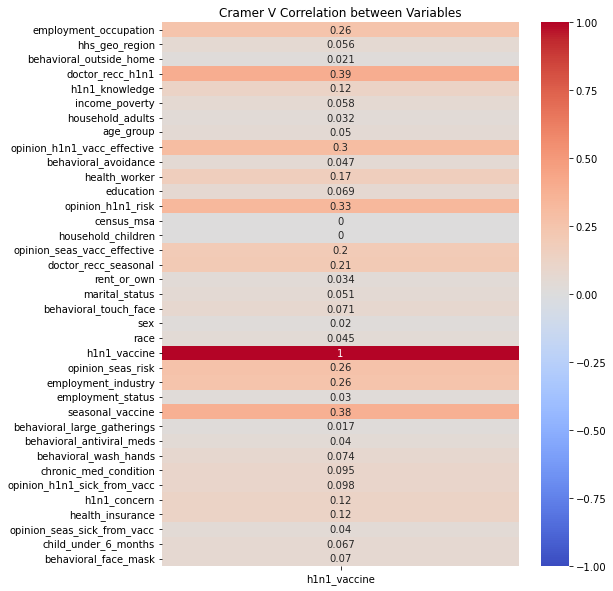

In [173]:
heatmap_categorical_columns_w_dependant_categorical(joined_df, 'h1n1_vaccine' , categorical_cols)

<AxesSubplot:title={'center':'Cramer V Correlation between Variables'}>

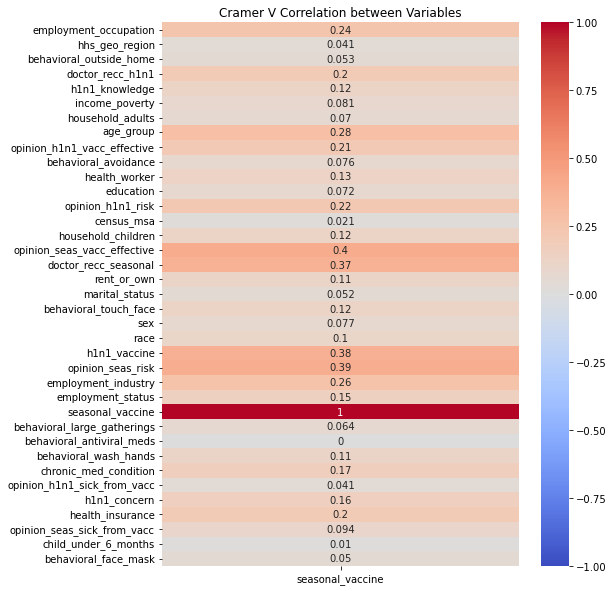

In [174]:
heatmap_categorical_columns_w_dependant_categorical(joined_df, 'seasonal_vaccine' , categorical_cols)

In [175]:
corr = joined_df.corr()

corrM_h1n1 = [cramers_v(joined_df['h1n1_vaccine'], joined_df[column]) for column in categorical_cols]
corr_h1n1 = pd.DataFrame(corrM_h1n1, index=categorical_cols, columns=['h1n1_vaccine'])


corrM_seasonal = [cramers_v(joined_df['seasonal_vaccine'], joined_df[column]) for column in categorical_cols]
corr_seasonal = pd.DataFrame(corrM_seasonal, index=categorical_cols, columns=['seasonal_vaccine'])

37
                             h1n1_vaccine
employment_occupation               0.255
hhs_geo_region                      0.056
behavioral_outside_home             0.021
doctor_recc_h1n1                    0.394
h1n1_knowledge                      0.122
income_poverty                      0.058
household_adults                    0.032
age_group                           0.050
opinion_h1n1_vacc_effective         0.304
behavioral_avoidance                0.047
health_worker                       0.170
education                           0.069
opinion_h1n1_risk                   0.329
census_msa                          0.000
household_children                  0.000
opinion_seas_vacc_effective         0.196
doctor_recc_seasonal                0.210
rent_or_own                         0.034
marital_status                      0.051
behavioral_touch_face               0.071
sex                                 0.020
race                                0.045
h1n1_vaccine                   

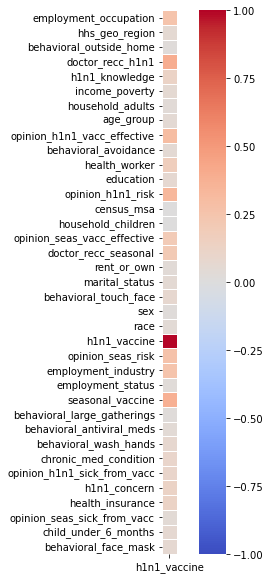

In [176]:
print(len(corr_h1n1))
print(corr_h1n1)

plt.figure(figsize=(8, 10))
ax1 = sns.heatmap(corr_h1n1, linewidths=1,
            cmap='coolwarm', vmax=1, vmin=-1, square=True)
plt.show()

37
                             seasonal_vaccine
employment_occupation                   0.244
hhs_geo_region                          0.041
behavioral_outside_home                 0.053
doctor_recc_h1n1                        0.198
h1n1_knowledge                          0.121
income_poverty                          0.081
household_adults                        0.070
age_group                               0.285
opinion_h1n1_vacc_effective             0.215
behavioral_avoidance                    0.076
health_worker                           0.127
education                               0.072
opinion_h1n1_risk                       0.221
census_msa                              0.021
household_children                      0.121
opinion_seas_vacc_effective             0.400
doctor_recc_seasonal                    0.369
rent_or_own                             0.111
marital_status                          0.052
behavioral_touch_face                   0.120
sex                            

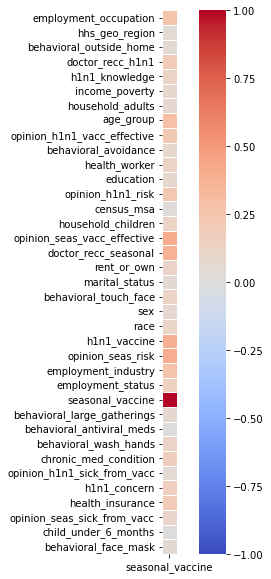

In [177]:
print(len(corr_seasonal))
print(corr_seasonal)

plt.figure(figsize=(8, 10))
ax1 = sns.heatmap(corr_seasonal, linewidths=1,
            cmap='coolwarm', vmax=1, vmin=-1, square=True)
plt.show()

## Conclusion

It seems that in categorical data, when we observe a feature against a label, when there is **little to no difference between category classes** (e.g. h1n1 and sex) we can safely **assume there is low or zero correlation**.

**Should there be a divided approach for the two labels?** ;since there are features which can be presumed to have no correlation for one label, and some correlation for another label, e.g. include some features for predicting h1n1 vaccination probability whilst excluding the same for seasonal vaccination?

There is some correlation between labels for the same feature, suggesting that feature is universally accepted as a criteria for prediction, whether feature for one label has same distribution, or scaled/standardized distribution for the second label, e.g. *employment industry* and *employment occupation*

We should reduce number of features based on correlation to the labels appropriately and seperately, and after that do some prediction according to the label correlation or how h1n1 vaccination is related to the seasonal vaccination.


# Data Wrangling

## Outlier detection

In [178]:
# # find unique elements per column
# unique_elements_per_column={i:train_features[i].unique() for i in train_features.columns}
# print(unique_elements_per_column)

# # create possible category combinations
# category_pairs=list(itertools.combinations(train_features.columns,len(train_features.columns)))
# #print(len(category_pairs[0]))

# # find all possible combinations by category pair
# all_possible_combinations=[list(itertools.product(unique_elements_per_column[i[0]],unique_elements_per_column[i[1]])) for i in category_pairs]
# all_possible_combinations
# # sum of all possible combinations by category pair
# sum_combinations=[len(i) for i in all_possible_combinations]
# df_out=pd.DataFrame(columns=['all_possible_combinations'],index=category_pairs,data=sum_combinations)

## Data cleaning

In [179]:
# print("Before dropping nan's",train_features.shape)
# train_features.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
# print("After dropping nan's", train_features.shape)

In [180]:
multiple_nan_rows_to_drop = 9
all_rows = train_features.shape[1] + train_labels.shape[1]

print(train_features.shape)
merged_df = pd.merge(train_features, train_labels, left_index=True, right_index=True)
merged_df = merged_df.dropna(thresh = all_rows - multiple_nan_rows_to_drop)

merged_df.shape

train_labels = merged_df[["h1n1_vaccine", "seasonal_vaccine"]]
train_features = merged_df.drop(columns=["h1n1_vaccine", "seasonal_vaccine"])
print(train_features.shape)

(26707, 35)
(25848, 35)


Since there is only **approximately 1/4 of the data left** when **dropping missing values**, we should devise some different strategy to handling missing values, perhaps assume **predictions** based on **correlation between features**, or **replacing them with most common values** (mean, median, mode) but that has some drawbacks in bias. Maybe we should implement a strategy where the distribution is kept in place while using the best prediction method based on feature correlation.

Data for some features are label encoded, they need to be one-hot encoded or target encoded, see https://towardsdatascience.com/handling-categorical-data-the-right-way-9d1279956fc6



In [181]:
threshold = 0.00

In [182]:
h1n1_vaccine_columns_to_keep = corr_h1n1.loc[abs(corr_h1n1['h1n1_vaccine']) >= threshold].index.tolist()
h1n1_vaccine_columns_to_keep.remove('h1n1_vaccine')
len(h1n1_vaccine_columns_to_keep)

36

In [183]:
seasonal_vaccine_columns_to_keep = corr_seasonal.loc[abs(corr_seasonal['seasonal_vaccine']) >= threshold].index.tolist()
seasonal_vaccine_columns_to_keep.remove('seasonal_vaccine')
len(seasonal_vaccine_columns_to_keep)

36

If the chosen approach is to **predict the labels together** with same columns, the columns to keep should be intersected

In [184]:
h1n1_vaccine_columns_to_keep = set(h1n1_vaccine_columns_to_keep)
seasonal_vaccine_columns_to_keep = set(seasonal_vaccine_columns_to_keep)

intersecting_columns = list(h1n1_vaccine_columns_to_keep.union(seasonal_vaccine_columns_to_keep))
intersecting_columns.remove('h1n1_vaccine')
intersecting_columns.remove('seasonal_vaccine')
print(intersecting_columns)
print(len(intersecting_columns))

['employment_occupation', 'hhs_geo_region', 'doctor_recc_h1n1', 'behavioral_outside_home', 'h1n1_knowledge', 'household_adults', 'age_group', 'opinion_h1n1_vacc_effective', 'behavioral_avoidance', 'health_worker', 'education', 'opinion_h1n1_risk', 'census_msa', 'household_children', 'opinion_seas_vacc_effective', 'doctor_recc_seasonal', 'rent_or_own', 'marital_status', 'behavioral_touch_face', 'sex', 'race', 'child_under_6_months', 'opinion_seas_risk', 'employment_industry', 'employment_status', 'behavioral_large_gatherings', 'behavioral_antiviral_meds', 'behavioral_wash_hands', 'chronic_med_condition', 'opinion_h1n1_sick_from_vacc', 'h1n1_concern', 'health_insurance', 'opinion_seas_sick_from_vacc', 'income_poverty', 'behavioral_face_mask']
35


In [185]:
train_features = train_features[intersecting_columns]
test_features = test_features[intersecting_columns]
train_features.shape

(25848, 35)

In [186]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

## Missing data

In [187]:
missing_values_df = []

train_features.isnull().sum().sort_values(ascending=False)

employment_occupation          12611
employment_industry            12472
health_insurance               11417
income_poverty                  3565
doctor_recc_seasonal            1933
doctor_recc_h1n1                1933
rent_or_own                     1185
employment_status                607
marital_status                   555
education                        554
chronic_med_condition            245
behavioral_avoidance             193
behavioral_touch_face            117
h1n1_knowledge                   109
opinion_h1n1_vacc_effective       88
behavioral_large_gatherings       80
h1n1_concern                      78
behavioral_outside_home           77
behavioral_antiviral_meds         66
opinion_h1n1_risk                 42
opinion_seas_vacc_effective       40
behavioral_wash_hands             35
opinion_seas_risk                 32
health_worker                     16
child_under_6_months              16
behavioral_face_mask              16
household_adults                  13
o

In [188]:
for col in train_features:
  print(col, " ", train_features[col].unique())

employment_occupation   [nan 'xgwztkwe' 'xtkaffoo' 'emcorrxb' 'vlluhbov' 'xqwwgdyp' 'ccgxvspp'
 'qxajmpny' 'kldqjyjy' 'mxkfnird' 'hfxkjkmi' 'bxpfxfdn' 'ukymxvdu'
 'cmhcxjea' 'haliazsg' 'dlvbwzss' 'xzmlyyjv' 'oijqvulv' 'rcertsgn'
 'tfqavkke' 'hodpvpew' 'uqqtjvyb' 'pvmttkik' 'dcjcmpih']
hhs_geo_region   ['oxchjgsf' 'bhuqouqj' 'qufhixun' 'lrircsnp' 'atmpeygn' 'lzgpxyit'
 'fpwskwrf' 'mlyzmhmf' 'dqpwygqj' 'kbazzjca']
doctor_recc_h1n1   [ 0. nan  1.]
behavioral_outside_home   [ 1.  0. nan]
h1n1_knowledge   [ 0.  2.  1. nan]
household_adults   [ 0.  2.  1.  3. nan]
age_group   ['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']
opinion_h1n1_vacc_effective   [ 3.  5.  4.  2.  1. nan]
behavioral_avoidance   [ 0.  1. nan]
health_worker   [ 0.  1. nan]
education   ['< 12 Years' '12 Years' 'College Graduate' 'Some College' nan]
opinion_h1n1_risk   [ 1.  4.  3.  2.  5. nan]
census_msa   ['Non-MSA' 'MSA, Not Principle  City' 'MSA, Principle City']
household_children   [ 0.

Replacing employee industry and occupation with some other value if they are not employed, other than NaN

In [189]:
if "employment_status" in train_features.columns.tolist():
  employment_status = train_features[train_features["employment_status"] == 'Not in Labor Force']
  employment_status = employment_status[['employment_status','employment_industry','employment_occupation']]
  for col in employment_status:
    print(col, " ", employment_status[col].unique())
  print(employment_status.shape)

employment_status   ['Not in Labor Force']
employment_industry   [nan]
employment_occupation   [nan]
(10229, 3)


In [190]:
if "employment_status" in train_features.columns.tolist():
  if "employment_industry" in train_features.columns.tolist():
    train_features.loc[train_features['employment_status'] == 'Not in Labor Force', 'employment_industry'] = 'not_in_labor_force'
    train_features.loc[train_features['employment_status'] == 'Unemployed', 'employment_industry'] = 'unemployed'

    test_features.loc[test_features['employment_status'] == 'Not in Labor Force', 'employment_industry'] = 'not_in_labor_force'
    test_features.loc[test_features['employment_status'] == 'Unemployed', 'employment_industry'] = 'unemployed'

  if "employment_occupation" in train_features.columns.tolist():
    train_features.loc[train_features['employment_status'] == 'Not in Labor Force', 'employment_occupation'] = 'not_in_labor_force'
    train_features.loc[train_features['employment_status'] == 'Unemployed', 'employment_occupation'] = 'unemployed'

    test_features.loc[test_features['employment_status'] == 'Not in Labor Force', 'employment_occupation'] = 'not_in_labor_force'
    test_features.loc[test_features['employment_status'] == 'Unemployed', 'employment_occupation'] = 'unemployed'

Replacing Nan with 0 in health insurance, supposedly people didn't input health insurance because they don't have it

In [191]:
train_features['health_insurance'] = train_features['health_insurance'].fillna(0)
test_features['health_insurance'] = test_features['health_insurance'].fillna(0)

train_features['income_poverty'] = train_features['income_poverty'].fillna('> $75,000')
test_features['income_poverty'] = test_features['income_poverty'].fillna('> $75,000')

train_features['doctor_recc_h1n1'] = train_features['doctor_recc_h1n1'].fillna(0)
test_features['doctor_recc_h1n1'] = test_features['doctor_recc_h1n1'].fillna(0)

train_features['rent_or_own'] = train_features['rent_or_own'].fillna('other')
test_features['rent_or_own'] = test_features['rent_or_own'].fillna('other')

# train_features['doctor_recc_seasonal'] = train_features['doctor_recc_seasonal'].fillna(1)
# test_features['doctor_recc_seasonal'] = test_features['doctor_recc_seasonal'].fillna(1)

train_features['employment_status'] = train_features['employment_status'].fillna('Unemployed')
test_features['employment_status'] = test_features['employment_status'].fillna('Unemployed')

# train_features['marital_status'] = train_features['marital_status'].fillna('Married')
# test_features['marital_status'] = test_features['marital_status'].fillna('Married')

# train_features['marital_status'] = train_features['marital_status'].fillna('other')
# test_features['marital_status'] = test_features['marital_status'].fillna('other')

# train_features['employment_status'] = train_features['employment_status'].fillna('Unemployed')
# test_features['employment_status'] = test_features['employment_status'].fillna('Unemployed')

In [192]:
for col in train_features:
  print(col, " ", train_features[col].unique())

employment_occupation   ['not_in_labor_force' 'xgwztkwe' 'xtkaffoo' 'emcorrxb' 'vlluhbov'
 'xqwwgdyp' 'ccgxvspp' 'qxajmpny' 'kldqjyjy' 'mxkfnird' 'unemployed'
 'hfxkjkmi' 'bxpfxfdn' 'ukymxvdu' 'cmhcxjea' 'haliazsg' 'dlvbwzss' nan
 'xzmlyyjv' 'oijqvulv' 'rcertsgn' 'tfqavkke' 'hodpvpew' 'uqqtjvyb'
 'pvmttkik' 'dcjcmpih']
hhs_geo_region   ['oxchjgsf' 'bhuqouqj' 'qufhixun' 'lrircsnp' 'atmpeygn' 'lzgpxyit'
 'fpwskwrf' 'mlyzmhmf' 'dqpwygqj' 'kbazzjca']
doctor_recc_h1n1   [0. 1.]
behavioral_outside_home   [ 1.  0. nan]
h1n1_knowledge   [ 0.  2.  1. nan]
household_adults   [ 0.  2.  1.  3. nan]
age_group   ['55 - 64 Years' '35 - 44 Years' '18 - 34 Years' '65+ Years'
 '45 - 54 Years']
opinion_h1n1_vacc_effective   [ 3.  5.  4.  2.  1. nan]
behavioral_avoidance   [ 0.  1. nan]
health_worker   [ 0.  1. nan]
education   ['< 12 Years' '12 Years' 'College Graduate' 'Some College' nan]
opinion_h1n1_risk   [ 1.  4.  3.  2.  5. nan]
census_msa   ['Non-MSA' 'MSA, Not Principle  City' 'MSA, Principle Cit

In [193]:
if "doctor_recc_h1n1" in train_features.columns.tolist():
  employment_status = train_features[train_features["employment_status"].isna()]
  employment_status = employment_status[['employment_status','age_group','education']]
  for col in employment_status:
    print(col, " ", employment_status[col].unique())
  print(employment_status.shape)
  
#print(employment_status['health_insurance'].value_counts())

employment_status   []
age_group   []
education   []
(0, 3)


In [194]:
train_features.isnull().sum().sort_values(ascending=False)

doctor_recc_seasonal           1933
employment_occupation           929
employment_industry             790
marital_status                  555
education                       554
chronic_med_condition           245
behavioral_avoidance            193
behavioral_touch_face           117
h1n1_knowledge                  109
opinion_h1n1_vacc_effective      88
behavioral_large_gatherings      80
h1n1_concern                     78
behavioral_outside_home          77
behavioral_antiviral_meds        66
opinion_h1n1_risk                42
opinion_seas_vacc_effective      40
behavioral_wash_hands            35
opinion_seas_risk                32
child_under_6_months             16
behavioral_face_mask             16
health_worker                    16
household_adults                 13
household_children               13
opinion_h1n1_sick_from_vacc      13
opinion_seas_sick_from_vacc      10
race                              0
hhs_geo_region                    0
doctor_recc_h1n1            

In [195]:
from sklearn.preprocessing import LabelEncoder

def unique_non_null(s):
    return s.dropna().unique()

#print(train_features.columns.tolist())
nominal_not_encoded_columns = ['hhs_geo_region','employment_status', 'employment_industry', 'employment_occupation', 'marital_status', 'rent_or_own', 'sex', 'census_msa', 'race']
nominal_two_var_not_encoded_columns = []
# encoding 2 value nominal variables into 0 and 1 instead of making 2 seperate variables in pd.get_dummies
label_encoder_nominal = LabelEncoder()
for col in nominal_not_encoded_columns:
  # Key Error handling
  if col in train_features.columns.tolist():
  #print(train_features[col].unique())
  #print(len(train_features[col].unique()))
    if(len(unique_non_null(train_features[col])) == 2):
      train_features[col] = label_encoder_nominal.fit_transform(train_features[col])
      test_features[col] = label_encoder_nominal.fit_transform(test_features[col])
      nominal_two_var_not_encoded_columns.append(col)
      print(train_features[col])

nominal_two_plus_var_not_encoded_columns = list(set(nominal_not_encoded_columns) - set(nominal_two_var_not_encoded_columns))
print(nominal_two_plus_var_not_encoded_columns)

# Key Error handling
nominal_two_plus_var_not_encoded_columns_intersection = set(nominal_two_plus_var_not_encoded_columns).intersection(set(train_features.columns.tolist()))

if(len(nominal_two_plus_var_not_encoded_columns_intersection) != 0):
  train_features = pd.get_dummies(train_features, prefix=nominal_two_plus_var_not_encoded_columns_intersection, columns=nominal_two_plus_var_not_encoded_columns_intersection)
  train_features.columns.tolist()
  test_features = pd.get_dummies(test_features, prefix=nominal_two_plus_var_not_encoded_columns_intersection, columns=nominal_two_plus_var_not_encoded_columns_intersection)
  train_features.columns.tolist()

# TO DO - label encode below column
ordinal_not_encoded_columns = ['education', 'age_group', 'income_poverty']
label_encoder = LabelEncoder()
for col in ordinal_not_encoded_columns:
  # Key Error handling
  if col in train_features.columns.tolist():
    train_features[col] = label_encoder.fit_transform(train_features[col])
    test_features[col] = label_encoder.fit_transform(test_features[col])
    print(train_features[col])

respondent_id
0        1
1        1
2        1
3        1
4        0
        ..
26702    1
26703    1
26704    1
26705    0
26706    0
Name: marital_status, Length: 25848, dtype: int32
respondent_id
0        0
1        1
2        1
3        0
4        0
        ..
26702    0
26703    1
26704    0
26705    0
26706    1
Name: sex, Length: 25848, dtype: int32
['race', 'employment_occupation', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_status', 'rent_or_own']
respondent_id
0        1
1        0
2        2
3        0
4        3
        ..
26702    3
26703    2
26704    3
26705    3
26706    3
Name: education, Length: 25848, dtype: int32
respondent_id
0        3
1        1
2        0
3        4
4        2
        ..
26702    4
26703    0
26704    3
26705    0
26706    4
Name: age_group, Length: 25848, dtype: int32
respondent_id
0        2
1        2
2        0
3        2
4        0
        ..
26702    0
26703    0
26704    1
26705    0
26706    0
Name: income_poverty,

C:\Users\Darko Segvic\AppData\Local\Temp\ipykernel_12976\1024639940.py:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_features = pd.get_dummies(train_features, prefix=nominal_two_plus_var_not_encoded_columns_intersection, columns=nominal_two_plus_var_not_encoded_columns_intersection)
C:\Users\Darko Segvic\AppData\Local\Temp\ipykernel_12976\1024639940.py:31: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  test_features = pd.get_dummies(test_features, prefix=nominal_two_plus_var_not_encoded_columns_intersection, columns=nominal_two_plus_var_not_encoded_columns_intersection)


In [196]:
ordinal_values = [1, 2, 3, 4, 5, np.nan]
ordinal_cols = []
for col in train_features:
  if train_features[col].isin(ordinal_values).all():
    ordinal_cols.append(col)

ordinal_cols.append('h1n1_concern')
ordinal_cols.append('h1n1_knowledge')
ordinal_cols.append('education')
ordinal_cols.append('income_poverty')
ordinal_cols.append('age_group')

print('Ordinal columns are :', ordinal_cols)


nominal_values = [0, 1, np.nan]
nominal_values_notencoded = [type(str), type(str), np.nan]
nominal_cols = []
for col in train_features:
  if (train_features[col].isin(nominal_values).all()) :
    nominal_cols.append(col)

print('Nominal columns are :', nominal_cols)

nominal_cols.append('hhs_geo_region')
nominal_cols.append('employment_industry')
nominal_cols.append('employment_occupation')
nominal_cols.append('employment_status')
nominal_cols.append('marital_status')
nominal_cols.append('rent_or_own')
nominal_cols.append('race')

categorical_cols = ordinal_cols + nominal_cols
categorical = list(set(categorical_cols).intersection(set(train_features.columns.tolist())))
print(categorical_cols)

numerical_cols = list(set(train_features.columns.tolist()) - set(categorical_cols))
#numerical_cols = train_features.columns.tolist() - categorical_cols
print(numerical_cols)


Ordinal columns are : ['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc', 'h1n1_concern', 'h1n1_knowledge', 'education', 'income_poverty', 'age_group']
Nominal columns are : ['doctor_recc_h1n1', 'behavioral_outside_home', 'behavioral_avoidance', 'health_worker', 'doctor_recc_seasonal', 'behavioral_touch_face', 'sex', 'child_under_6_months', 'behavioral_large_gatherings', 'behavioral_antiviral_meds', 'behavioral_wash_hands', 'chronic_med_condition', 'health_insurance', 'behavioral_face_mask', 'race_Black', 'race_Hispanic', 'race_Other or Multiple', 'race_White', 'employment_occupation_bxpfxfdn', 'employment_occupation_ccgxvspp', 'employment_occupation_cmhcxjea', 'employment_occupation_dcjcmpih', 'employment_occupation_dlvbwzss', 'employment_occupation_emcorrxb', 'employment_occupation_haliazsg', 'employment_occupation_hfxkjkmi', 'employment_occupation_hodpvpew', 'employment

In [197]:
for col in train_features:
  print(col, " ", train_features[col].unique())

doctor_recc_h1n1   [0. 1.]
behavioral_outside_home   [ 1.  0. nan]
h1n1_knowledge   [ 0.  2.  1. nan]
household_adults   [ 0.  2.  1.  3. nan]
age_group   [3 1 0 4 2]
opinion_h1n1_vacc_effective   [ 3.  5.  4.  2.  1. nan]
behavioral_avoidance   [ 0.  1. nan]
health_worker   [ 0.  1. nan]
education   [1 0 2 3 4]
opinion_h1n1_risk   [ 1.  4.  3.  2.  5. nan]
household_children   [ 0.  3.  2.  1. nan]
opinion_seas_vacc_effective   [ 2.  4.  5.  3.  1. nan]
doctor_recc_seasonal   [ 0. nan  1.]
marital_status   [1 0 2]
behavioral_touch_face   [ 1.  0. nan]
sex   [0 1]
child_under_6_months   [ 0.  1. nan]
opinion_seas_risk   [ 1.  2.  4.  3.  5. nan]
behavioral_large_gatherings   [ 0.  1. nan]
behavioral_antiviral_meds   [ 0.  1. nan]
behavioral_wash_hands   [ 0.  1. nan]
chronic_med_condition   [ 0.  1. nan]
opinion_h1n1_sick_from_vacc   [ 2.  4.  1.  5.  3. nan]
h1n1_concern   [ 1.  3.  2.  0. nan]
health_insurance   [1. 0.]
opinion_seas_sick_from_vacc   [ 2.  4.  1.  5.  3. nan]
income_p

##Feature engineering

In [198]:
# seas_overall_opinion = [i for i in train_features.columns.tolist() if 'seas' in i]
# print(seas_overall_opinion)

# train_features["seas_overall_opinion"] = train_features[seas_overall_opinion].prod(axis=1) #sum prod
# test_features["seas_overall_opinion"] = test_features[seas_overall_opinion].prod(axis=1) 
# categorical_cols.append("seas_overall_opinion")

In [199]:
# h1n1_overall_opinion = [i for i in train_features.columns.tolist() if 'h1n1' in i]
# print(h1n1_overall_opinion)

# train_features["h1n1_overall_opinion"] = train_features[h1n1_overall_opinion].prod(axis=1) #sum
# test_features["h1n1_overall_opinion"] = test_features[h1n1_overall_opinion].prod(axis=1) #sum
# categorical_cols.append("h1n1_overall_opinion")

In [200]:
#median_cols = []
median_cols = ['opinion_seas_sick_from_vacc','opinion_seas_risk','income_poverty', 'opinion_h1n1_sick_from_vacc', 'h1n1_knowledge', 'h1n1_concern', 'opinion_seas_vacc_effective','household_children', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'education']
# 'opinion_h1n1_sick_from_vacc', 'h1n1_knowledge', 'h1n1_concern', 'opinion_seas_vacc_effective','household_children', 'opinion_h1n1_vacc_effective', 'age_group','opinion_h1n1_risk', 'education'
#'age_group',

for col in median_cols:
  train_features[f"{col}_median"] = (train_features[col] > train_features[col].median()).astype(int)
  test_features[f"{col}_median"] = (test_features[col] > test_features[col].median()).astype(int)
  categorical_cols.append(f"{col}_median")

mean_cols = []
# 'household_children', 'household_adults', 'age_group', 'household_children'

for col in mean_cols:
  train_features[f"{col}_mean"] = (train_features[col] > train_features[col].mean()).astype(int)
  test_features[f"{col}_mean"] = (test_features[col] > test_features[col].mean()).astype(int)
  categorical_cols.append(f"{col}_mean")


In [201]:
# behavioral_cols = [i for i in train_features.columns.tolist() if i.startswith('behavioral')]
# print(behavioral_cols)

# train_features["behavioral"] = train_features[behavioral_cols].sum(axis=1) #sum prod
# test_features["behavioral"] = test_features[behavioral_cols].sum(axis=1)
# categorical_cols.append("behavioral")

In [202]:
# train_features["behavioral"].unique()

In [203]:
categorical_cols

['opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_sick_from_vacc',
 'h1n1_concern',
 'h1n1_knowledge',
 'education',
 'income_poverty',
 'age_group',
 'doctor_recc_h1n1',
 'behavioral_outside_home',
 'behavioral_avoidance',
 'health_worker',
 'doctor_recc_seasonal',
 'behavioral_touch_face',
 'sex',
 'child_under_6_months',
 'behavioral_large_gatherings',
 'behavioral_antiviral_meds',
 'behavioral_wash_hands',
 'chronic_med_condition',
 'health_insurance',
 'behavioral_face_mask',
 'race_Black',
 'race_Hispanic',
 'race_Other or Multiple',
 'race_White',
 'employment_occupation_bxpfxfdn',
 'employment_occupation_ccgxvspp',
 'employment_occupation_cmhcxjea',
 'employment_occupation_dcjcmpih',
 'employment_occupation_dlvbwzss',
 'employment_occupation_emcorrxb',
 'employment_occupation_haliazsg',
 'employment_occupation_hfxkjkmi',
 'employment_occupation_hodpvpew',
 'employment_occupa

In [204]:
numerical_cols

['household_children', 'household_adults']

In [205]:
print(categorical_cols)
print(numerical_cols)
print(len(categorical_cols + numerical_cols))
print(len(train_features.columns.tolist()))

['opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_sick_from_vacc', 'h1n1_concern', 'h1n1_knowledge', 'education', 'income_poverty', 'age_group', 'doctor_recc_h1n1', 'behavioral_outside_home', 'behavioral_avoidance', 'health_worker', 'doctor_recc_seasonal', 'behavioral_touch_face', 'sex', 'child_under_6_months', 'behavioral_large_gatherings', 'behavioral_antiviral_meds', 'behavioral_wash_hands', 'chronic_med_condition', 'health_insurance', 'behavioral_face_mask', 'race_Black', 'race_Hispanic', 'race_Other or Multiple', 'race_White', 'employment_occupation_bxpfxfdn', 'employment_occupation_ccgxvspp', 'employment_occupation_cmhcxjea', 'employment_occupation_dcjcmpih', 'employment_occupation_dlvbwzss', 'employment_occupation_emcorrxb', 'employment_occupation_haliazsg', 'employment_occupation_hfxkjkmi', 'employment_occupation_hodpvpew', 'employment_occupation_kldqjyjy', 'employment_occupation

In [206]:
categorical_cols = list(set(categorical_cols).intersection(set(train_features.columns.tolist())))
numerical_cols = list(set(numerical_cols).intersection(set(train_features.columns.tolist())))

In [207]:
print(categorical_cols)
print(numerical_cols)
print(len(categorical_cols + numerical_cols))
print(len(train_features.columns.tolist()))

['hhs_geo_region_fpwskwrf', 'employment_occupation_vlluhbov', 'census_msa_Non-MSA', 'employment_occupation_emcorrxb', 'opinion_h1n1_vacc_effective', 'behavioral_avoidance', 'health_worker', 'employment_occupation_dcjcmpih', 'race_Black', 'opinion_seas_vacc_effective', 'opinion_h1n1_vacc_effective_median', 'hhs_geo_region_mlyzmhmf', 'behavioral_touch_face', 'sex', 'employment_occupation_haliazsg', 'employment_occupation_tfqavkke', 'employment_occupation_cmhcxjea', 'opinion_h1n1_risk_median', 'employment_industry_rucpziij', 'rent_or_own_Rent', 'h1n1_concern', 'employment_industry_arjwrbjb', 'employment_occupation_dlvbwzss', 'opinion_seas_sick_from_vacc', 'behavioral_face_mask', 'employment_industry_nduyfdeo', 'doctor_recc_h1n1', 'h1n1_knowledge', 'age_group', 'hhs_geo_region_qufhixun', 'employment_industry_saaquncn', 'employment_occupation_ccgxvspp', 'employment_status_Employed', 'employment_status_Unemployed', 'opinion_h1n1_risk', 'census_msa_MSA, Not Principle  City', 'employment_indus

In [208]:
print(len(categorical_cols + numerical_cols))

110


# Model 

In [209]:
train_features

,doctor_recc_h1n1,behavioral_outside_home,h1n1_knowledge,household_adults,age_group,opinion_h1n1_vacc_effective,behavioral_avoidance,health_worker,education,opinion_h1n1_risk,household_children,opinion_seas_vacc_effective,doctor_recc_seasonal,marital_status,behavioral_touch_face,sex,child_under_6_months,opinion_seas_risk,behavioral_large_gatherings,behavioral_antiviral_meds,behavioral_wash_hands,chronic_med_condition,opinion_h1n1_sick_from_vacc,h1n1_concern,health_insurance,opinion_seas_sick_from_vacc,income_poverty,behavioral_face_mask,race_Black,race_Hispanic,race_Other or Multiple,race_White,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_not_in_labor_force,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,...,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_not_in_labor_force,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_unemployed,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,rent_or_own_Own,rent_or_own_Rent,rent_or_own_other,opinion_seas_sick_from_vacc_median,opinion_seas_risk_median,income_poverty_median,opinion_h1n1_sick_from_vacc_median,h1n1_knowledge_median,h1n1_concern_median,opinion_seas_vacc_effective_median,household_children_median,opinion_h1n1_vacc_effective_median,opinion_h1n1_risk_median,education_median
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,0.0,3,3.0,0.0,0.0,1,1.0,0.0,2.0,0.0,1,1.0,0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,2,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0.0,1.0,2.0,0.0,1,5.0,1.0,0.0,0,4.0,0.0,4.0,0.0,1,1.0,1,0.0,2.0,0.0,0.0,1.0,0.0,4.0,3.0,1.0,4.0,2,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,1,1,0,0,1,1,0
2,0.0,0.0,1.0,2.0,0,3.0,1.0,0.0,2,1.0,0.0,4.0,NaN,1,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,1.0,0.0,4,3.0,1.0,0.0,0,3.0,0.0,5.0,1.0,1,0.0,0,0.0,4.0,1.0,0.0,1.0,1.0,5.0,1.0,0.0,1.0,2,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,1,0,0,1,0
4,0.0,0.0,1.0,1.0,2,3.0,1.0,0.0,3,3.0,0.0,3.0,0.0,0,1.0,0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,4.0,0,0.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [210]:
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', MinMaxScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

n_neighbors = 51

categorical_preprocessing_steps = Pipeline([
    #('one_hot_encoding', OneHotEncoder(handle_unknown="ignore"))
    ('knn_imputer', KNNImputer(missing_values=np.nan, n_neighbors=n_neighbors)),
    ('min_max_scaler', MinMaxScaler())
])


# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
preprocessor = ColumnTransformer(
    transformers = [
        ("categorical", categorical_preprocessing_steps, categorical_cols),
        ("numeric", numeric_preprocessing_steps, numerical_cols)
    ],
    remainder = "drop"
)

In [211]:
!pip install xgboost

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# xgb.XGBClassifier(verbosity=3)

Defaulting to user installation because normal site-packages is not writeable


## Select model



In [212]:
estimator = MultiOutputClassifier(
    estimator = xgb.XGBClassifier(verbosity=0)
)

In [213]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", estimator),
])

In [214]:
full_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=51)),
                                                                  ('min_max_scaler',
                                                                   MinMaxScaler())]),
                                                  ['hhs_geo_region_fpwskwrf',
                                                   'employment_occupation_vlluhbov',
                                                   'census_msa_Non-MSA',
                                                   'employment_occupation_emcorrxb',
                                                   'opinion_h1n1_vacc_effective',
                                                   'behavioral_avoidance',
                                                   'health_w...
           

When choosing params in CV, key must be present in below dictionary

In [215]:
full_pipeline.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'clf', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__categorical', 'preprocessor__numeric', 'preprocessor__categorical__memory', 'preprocessor__categorical__steps', 'preprocessor__categorical__verbose', 'preprocessor__categorical__knn_imputer', 'preprocessor__categorical__min_max_scaler', 'preprocessor__categorical__knn_imputer__add_indicator', 'preprocessor__categorical__knn_imputer__copy', 'preprocessor__categorical__knn_imputer__metric', 'preprocessor__categorical__knn_imputer__missing_values', 'preprocessor__categorical__knn_imputer__n_neighbors', 'preprocessor__categorical__knn_imputer__weights', 'preprocessor__categorical__min_max_scaler__clip', 'preprocessor__categorical__min_max_scaler__copy', 'preprocessor__categorical__min_max_scaler_

## Train-test split

In [216]:
test_size=0.65

X_train, X_eval, y_train, y_eval = train_test_split(
    train_features,
    train_labels,
    test_size=test_size,
    shuffle=True,
    stratify=train_labels,
    random_state=RANDOM_SEED
)

# Hyperparameter optimization

In [217]:
def centerlin(center, step, nosteps, dtype):
    minus = np.linspace(center,center - step * nosteps , nosteps +1 , dtype = dtype)
    #print(minus)
    plus = np.linspace(center, center + step * nosteps, nosteps +1, dtype = dtype)
    #print(plus)
    listnumbers = list(set(minus).union(set(plus)))
    listnumbers.sort()
    return listnumbers
    

def centerlog(center, step, nosteps, dtype):
    minus = np.logspace(center,center - step * nosteps , nosteps +1 , dtype = dtype)
    #print(minus)
    plus = np.logspace(center, center + step * nosteps, nosteps +1, dtype = dtype)
    #print(plus)
    listnumbers = list(set(minus).union(set(plus)))
    listnumbers.sort()
    return listnumbers

In [218]:
params_RFC = {
    # 'clf__estimator__n_estimators': list(np.linspace(50, 4000, int((4000-50)/500) + 1, dtype=int)),
    'clf__estimator__max_depth': list(np.linspace(1,300, 15, dtype=int)),
    'clf__estimator__min_samples_split': list(np.linspace(2,300, 15, dtype=int)),
    'clf__estimator__min_samples_leaf': list(np.linspace(1,250, 15, dtype=int)),
    'clf__estimator__bootstrap': [True, False],
    'clf__estimator__criterion': ['gini', 'entropy']
}

params_LR = {
    'clf__estimator__C': np.logspace(-12, 12, 50),
    'clf__estimator__penalty': ['l1', 'l2'],
}

params_KNN = {
    'clf__estimator__leaf_size': list(np.linspace(1,100, 10, dtype=int)),
    'clf__estimator__n_neighbors': list(filter(lambda x: x%2 != 0, list(range(20,60)))),
    #'clf__estimator__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'clf__estimator__p': [1, 2, 3, 4]                                
}

params_SVC = {
    'clf__estimator__C': list(np.logspace(-2, 2, 5)),
    'clf__estimator__gamma': list(np.logspace(-2, 2, 5)),
    'clf__estimator__kernel': ['linear', 'sigmoid']
}

params_GNB = {
    'clf__estimator__var_smoothing': list(np.logspace(-2, 2, 50)),
}

params_GB = {
    'clf__estimator__learning_rate': list(np.logspace(-5,1, 5)),
    'clf__estimator__n_estimators': list(np.linspace(50, 500, 5, dtype=int)),
    'clf__estimator__max_depth': list(np.linspace(1, 32, 10, endpoint=True)),
    'clf__estimator__min_samples_split': list(np.linspace(0.1, 1.0, 10, endpoint=True)),
    'clf__estimator__min_samples_leaf':list(np.linspace(0.1, 0.5, 5, endpoint=True)),
    'clf__estimator__max_features':list(np.linspace(1,train_features.shape[1], 5, dtype=int))
}

params_XGB = {
    "clf__estimator__learning_rate": list(np.logspace(-5,1, 20)),
    "clf__estimator__max_depth": list(np.linspace(1, 50, 10, endpoint=True,dtype=int)),
    "clf__estimator__min_child_weight": list(np.logspace(1, 3, 20, endpoint=True)),
    "clf__estimator__gamma": list(np.logspace(-3, 3, 20)),
    "clf__estimator__colsample_bytree": list(np.logspace(-3, 0, 20)),
    "clf__estimator__colsample_bylevel": list(np.logspace(-2, -1, 20)),
    "clf__estimator__colsample_bynode": list(np.logspace(-2, -1, 10)),
    "clf__estimator__max_delta_step": list(np.logspace(-1.2,-0.6,10)),
    'clf__estimator__reg_lambda': list(np.logspace(-1,5,20)),
    'clf__estimator__reg_alpha': list(np.logspace(0.5,1.5,15))
}

In [219]:
def determine_params(pipeline):

  pipeline_estimator_class = pipeline.steps[1][1].estimator.__class__

  RFC = RandomForestClassifier().__class__
  LR = LogisticRegression().__class__
  KNN = KNeighborsClassifier().__class__
  SVM = svm.SVC().__class__
  GNB = GaussianNB().__class__
  GB = GradientBoostingClassifier().__class__
  XGB = xgb.XGBClassifier().__class__

  if pipeline_estimator_class == RFC :
    params = params_RFC
  elif pipeline_estimator_class == LR :
    params = params_LR
  elif pipeline_estimator_class == KNN :
    params = params_KNN
  elif pipeline_estimator_class == SVM :
    params = params_SVC
  elif pipeline_estimator_class == GNB :
    params = params_GNB
  elif pipeline_estimator_class == GB :
    params = params_GB
  elif pipeline_estimator_class == XGB :
    params = params_XGB
  
  return params

In [220]:
#params = determine_params(full_pipeline)
#params

## Validation curves

In [221]:
from sklearn.model_selection import validation_curve

def validation_curve_for_number_param(param_string, pipeline):
  param_range = params[param_string]

  #if not all(not isinstance(flag, str) for (flag) in param_range):
  #  return


  train_scores, test_scores = validation_curve(
      pipeline,
      X_train,
      y_train,
      param_name=param_string,
      param_range=param_range,
      scoring="roc_auc",
      n_jobs=-1,
      verbose=10
  )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.title("Validation Curve with Logistic Regression")
  plt.xlabel(param_string)
  plt.ylabel("Score")
  plt.xticks(range(len(param_range)), param_range, rotation=45)
  plt.ylim(0.75, 1.0)

  lw = 2
  plt.semilogx(
      param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
  )
  plt.fill_between(
      param_range,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.2,
      color="darkorange",
      lw=lw,
  )
  plt.semilogx(
      param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
  )
  plt.fill_between(
      param_range,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.2,
      color="navy",
      lw=lw,
  )
  plt.legend(loc="best")
  plt.grid(True)
  plt.show()

In [222]:
# for key in params:
#   validation_curve_for_number_param(key, full_pipeline)

In [223]:
params_RFC = {
    # 'clf__estimator__n_estimators': list(np.linspace(50, 4000, int((4000-50)/500) + 1, dtype=int)),
    'clf__estimator__max_depth': list(np.linspace(1,300, 15, dtype=int)),
    'clf__estimator__min_samples_split': list(np.linspace(2,300, 15, dtype=int)),
    'clf__estimator__min_samples_leaf': list(np.linspace(1,250, 15, dtype=int)),
    'clf__estimator__bootstrap': [True, False],
    'clf__estimator__criterion': ['gini', 'entropy']
}

params_LR = {
    'clf__estimator__C': np.logspace(-12, 12, 50),
    'clf__estimator__penalty': ['l1', 'l2'],
}

params_KNN = {
    'clf__estimator__leaf_size': list(np.linspace(1,100, 10, dtype=int)),
    'clf__estimator__n_neighbors': list(filter(lambda x: x%2 != 0, list(range(20,60)))),
    #'clf__estimator__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'clf__estimator__p': [1, 2, 3, 4]                                
}

params_SVC = {
    'clf__estimator__C': list(np.logspace(-2, 2, 5)),
    'clf__estimator__gamma': list(np.logspace(-2, 2, 5)),
    'clf__estimator__kernel': ['linear', 'sigmoid']
}

params_GNB = {
    'clf__estimator__var_smoothing': list(np.logspace(-2, 2, 50)),
}

params_GB = {
    'clf__estimator__learning_rate': list(np.logspace(-5,1, 10)),
    'clf__estimator__n_estimators': list(np.linspace(50, 500, 5, dtype=int)),
    'clf__estimator__max_depth': list(np.linspace(1, 10, 10, endpoint=True)),
    'clf__estimator__min_samples_split': list(np.logspace(-3, 0, 10, endpoint=True)),
    'clf__estimator__min_samples_leaf':list(np.linspace(0.1, 0.5, 5, endpoint=True)),
    'clf__estimator__max_features':list(np.linspace(1,train_features.shape[1], 5, dtype=int))
}

params_XGB = {
    "clf__estimator__learning_rate": list(np.linspace(0.01,0.15, 20)),
    "clf__estimator__max_depth": list(np.linspace(1, 50, 10, endpoint=True,dtype=int)),
    "clf__estimator__min_child_weight": list(np.logspace(1, 3, 20, endpoint=True)),
    "clf__estimator__gamma": list(np.logspace(-3, 3, 20)),
    "clf__estimator__colsample_bytree": list(np.logspace(-3, 0, 20)) 

    #"clf__estimator__learning_rate": list(np.logspace(-2,-1,10, endpoint=True)),
    #"clf__estimator__max_depth": list(np.linspace(1, 50, 6, endpoint=True,dtype=int)),
    #"clf__estimator__min_child_weight": list(np.logspace(1.5, 2.5, 10, endpoint=True)),
    #"clf__estimator__gamma": list(np.logspace(0.5, 1.5, 10)),
    #"clf__estimator__colsample_bytree": list(np.logspace(-1, 0, 5,endpoint=True)),
    #"clf__estimator__colsample_bylevel": list(np.append(np.logspace(-2, -1, 5),1)),
    #"clf__estimator__colsample_bynode": list(np.append(np.logspace(-2, -1, 5),1)),
    #"clf__estimator__max_delta_step": list(np.append(np.logspace(-1.2,-0.6,10),0)),
    #'clf__estimator__reg_lambda': list(np.append(np.logspace(1.5,3.25,10),1)),
    #'clf__estimator__reg_alpha': list(np.append(np.logspace(0.5,1.5,10),0))
}

params = determine_params(full_pipeline)
params

{'clf__estimator__learning_rate': [0.01,
  0.017368421052631578,
  0.024736842105263154,
  0.032105263157894734,
  0.039473684210526314,
  0.04684210526315789,
  0.054210526315789466,
  0.061578947368421046,
  0.06894736842105262,
  0.0763157894736842,
  0.08368421052631578,
  0.09105263157894736,
  0.09842105263157892,
  0.1057894736842105,
  0.11315789473684208,
  0.12052631578947366,
  0.12789473684210526,
  0.13526315789473684,
  0.14263157894736841,
  0.15],
 'clf__estimator__max_depth': [1, 6, 11, 17, 22, 28, 33, 39, 44, 50],
 'clf__estimator__min_child_weight': [10.0,
  12.742749857031335,
  16.237767391887218,
  20.6913808111479,
  26.366508987303583,
  33.59818286283781,
  42.81332398719393,
  54.5559478116852,
  69.51927961775606,
  88.58667904100822,
  112.88378916846884,
  143.8449888287663,
  183.29807108324357,
  233.57214690901213,
  297.63514416313194,
  379.26901907322497,
  483.2930238571752,
  615.8482110660261,
  784.7599703514607,
  1000.0],
 'clf__estimator__gamma

In [224]:
params

{'clf__estimator__learning_rate': [0.01,
  0.017368421052631578,
  0.024736842105263154,
  0.032105263157894734,
  0.039473684210526314,
  0.04684210526315789,
  0.054210526315789466,
  0.061578947368421046,
  0.06894736842105262,
  0.0763157894736842,
  0.08368421052631578,
  0.09105263157894736,
  0.09842105263157892,
  0.1057894736842105,
  0.11315789473684208,
  0.12052631578947366,
  0.12789473684210526,
  0.13526315789473684,
  0.14263157894736841,
  0.15],
 'clf__estimator__max_depth': [1, 6, 11, 17, 22, 28, 33, 39, 44, 50],
 'clf__estimator__min_child_weight': [10.0,
  12.742749857031335,
  16.237767391887218,
  20.6913808111479,
  26.366508987303583,
  33.59818286283781,
  42.81332398719393,
  54.5559478116852,
  69.51927961775606,
  88.58667904100822,
  112.88378916846884,
  143.8449888287663,
  183.29807108324357,
  233.57214690901213,
  297.63514416313194,
  379.26901907322497,
  483.2930238571752,
  615.8482110660261,
  784.7599703514607,
  1000.0],
 'clf__estimator__gamma

## Cross-Validation

In [225]:
from sklearn.model_selection import RandomizedSearchCV
import time

# params = 

n_iter = 200

t0 = time.time()
print("Fitting started...")
search = RandomizedSearchCV(full_pipeline, param_distributions=params, verbose=10, n_iter = n_iter, error_score="raise", cv=20) #error_score="raise"
search.fit(X_train, y_train)
print(f"Fitting took {time.time() - t0:0.3f}s.")

Fitting started...
Fitting 20 folds for each of 300 candidates, totalling 6000 fits
[CV 1/20; 1/300] START clf__estimator__colsample_bytree=0.4832930238571752, clf__estimator__gamma=0.008858667904100823, clf__estimator__learning_rate=0.054210526315789466, clf__estimator__max_depth=1, clf__estimator__min_child_weight=10.0
[CV 1/20; 1/300] END clf__estimator__colsample_bytree=0.4832930238571752, clf__estimator__gamma=0.008858667904100823, clf__estimator__learning_rate=0.054210526315789466, clf__estimator__max_depth=1, clf__estimator__min_child_weight=10.0;, score=0.673 total time=   1.7s
[CV 2/20; 1/300] START clf__estimator__colsample_bytree=0.4832930238571752, clf__estimator__gamma=0.008858667904100823, clf__estimator__learning_rate=0.054210526315789466, clf__estimator__max_depth=1, clf__estimator__min_child_weight=10.0
[CV 2/20; 1/300] END clf__estimator__colsample_bytree=0.4832930238571752, clf__estimator__gamma=0.008858667904100823, clf__estimator__learning_rate=0.054210526315789466

KeyboardInterrupt: 

In [ ]:
train_best_params = search.best_params_

In [ ]:
# from sklearn.model_selection import GridSearchCV
# import time

# t0 = time.time()
# print("Fitting started...")
# search = GridSearchCV(full_pipeline, param_grid=params, verbose=10)
# search.fit(X_train, y_train)
# print(f"Fitting took {time.time() - t0:0.3f}s.")

In [ ]:
#search.best_params_

In [ ]:
preds = search.predict_proba(X_eval)
preds

[array([[0.9528719 , 0.04712805],
        [0.9892326 , 0.01076742],
        [0.9883908 , 0.0116092 ],
        ...,
        [0.9823043 , 0.01769575],
        [0.91636014, 0.08363983],
        [0.8454616 , 0.15453842]], dtype=float32),
 array([[0.12263793, 0.8773621 ],
        [0.7356465 , 0.26435354],
        [0.9483554 , 0.05164461],
        ...,
        [0.30325252, 0.6967475 ],
        [0.02911305, 0.97088695],
        [0.20902276, 0.79097724]], dtype=float32)]

In [ ]:
print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

test_probas[0].shape (16802, 2)
test_probas[1].shape (16802, 2)


In [ ]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (16802, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
13115,0.047128,0.877362
8942,0.010767,0.264354
9780,0.011609,0.051645
3948,0.017111,0.902298
2021,0.277781,0.447003


In [ ]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

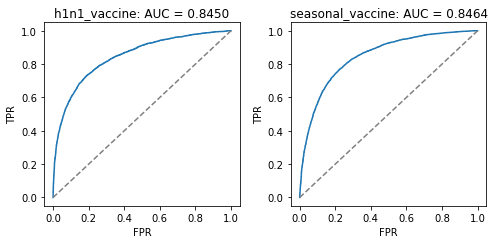

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

# Results

In [ ]:
roc_auc_score(y_eval, y_preds)

0.8456582685163816

In [ ]:
%%time 

# params = {

search.fit(train_features, train_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=300. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 20 folds for each of 1 candidates, totalling 20 fits
[CV 1/20; 1/1] START ...........................................................
[CV 1/20; 1/1] END ............................., score=0.673 total time=  23.1s
[CV 2/20; 1/1] START ...........................................................
[CV 2/20; 1/1] END ............................., score=0.680 total time=  23.1s
[CV 3/20; 1/1] START ...........................................................
[CV 3/20; 1/1] END ............................., score=0.679 total time=  22.9s
[CV 4/20; 1/1] START ...........................................................
[CV 4/20; 1/1] END ............................., score=0.685 total time=  22.8s
[CV 5/20; 1/1] START ...........................................................
[CV 5/20; 1/1] END ............................., score=0.668 total time=  22.4s
[CV 6/20; 1/1] START ...........................................................
[CV 6/20; 1/1] END .............................

RandomizedSearchCV(cv=20, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('categorical',
                                                                               Pipeline(steps=[('knn_imputer',
                                                                                                KNNImputer(n_neighbors=51)),
                                                                                               ('min_max_scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['hhs_geo_region_fpwskwrf',
                                                                                'employment_occupation_vlluhbov',
                                                                                'census_msa_Non-MSA',
         

In [ ]:
valid_best_params = search.best_params_

In [ ]:
test_probas = search.predict_proba(test_features)
test_probas

[array([[0.9475924 , 0.05240761],
        [0.97645247, 0.0235475 ],
        [0.9465779 , 0.05342209],
        ...,
        [0.8528693 , 0.14713074],
        [0.99346805, 0.00653194],
        [0.25342417, 0.74657583]], dtype=float32),
 array([[0.9495304 , 0.05046958],
        [0.932043  , 0.067957  ],
        [0.31246012, 0.6875399 ],
        ...,
        [0.8267244 , 0.17327556],
        [0.7791618 , 0.2208382 ],
        [0.5303804 , 0.46961957]], dtype=float32)]

## Submissions

In [ ]:
submission_df = pd.read_csv(r"C:\Development\FluShotLearning\data\submission_format.csv", index_col="respondent_id",engine='python')

In [ ]:
submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.5,0.7
26708,0.5,0.7
26709,0.5,0.7
26710,0.5,0.7
26711,0.5,0.7


In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.052408,0.050470
26708,0.023548,0.067957
26709,0.053422,0.687540
26710,0.695275,0.921373
26711,0.368002,0.467311


In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
submission_df.to_csv(f'{timestr}.csv', index=True)

In [ ]:
with mlflow.start_run():

  mlflow.log_param("estimator", full_pipeline.steps[1][1].estimator.__class__)
  mlflow.log_param("multiple_nan_rows_to_drop", multiple_nan_rows_to_drop)
  mlflow.log_param("threshold", threshold)
  mlflow.log_param("params", params)
  mlflow.log_param("KNN imputer", n_neighbors)
  mlflow.log_param("n-iterations", n_iter)
  mlflow.log_param("train best params", train_best_params)
  mlflow.log_param("validation best params", valid_best_params)
  mlflow.log_param("test size", test_size)
  mlflow.log_metric("h1n1 score", roc_auc_score(y_eval['h1n1_vaccine'], y_preds['h1n1_vaccine']))
  mlflow.log_metric("seasonal score", roc_auc_score(y_eval['seasonal_vaccine'], y_preds['seasonal_vaccine']))     
  mlflow.log_metric("score", roc_auc_score(y_eval, y_preds))  
  mlflow.log_artifact(f'{timestr}.csv')            

  # tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

  # if tracking_url_type_store != "file":
  #     mlflow.sklearn.log_model(rf, "model", registered_model_name="RandomForestModel")
  # else:
  #     mlflow.sklearn.log_model(rf, "model") 